In [17]:
from solr_manager import SolrManager

url = 'http://localhost:8983/solr/'
core = 'articles'
db = 'sqlite:///../data/articles.db'
solr = SolrManager(url, core, db)

Solr container with core articles started successfully.


In [70]:
# run if you want to change an existent schema (in case of error, wait for core to load)
solr.reload_core()

Core articles unloaded successfully.
Solr container with core articles stopped successfully.
Solr container with core articles started successfully.


In [48]:
# run if you want to delete all documents in the core (in case of error, wait for core to load)
solr.clear_documents()

Data cleared successfully.


Select **only one** of the following schemas to run!

In [71]:
schema = 'schema.json'
solr.submit_schema(schema)
solr.apply_stopwords('stopwords.txt')
solr.apply_synonyms('synonyms.txt')

Schema uploaded successfully.
Stopwords stored successfully.
Synonyms stored successfully.


In [19]:
schema = 'schema_weak.json'
solr.submit_schema(schema)
solr.apply_stopwords('stopwords.txt')

Schema uploaded successfully.
Stopwords stored successfully.


In [74]:
solr.index_articles(100)

Indexing 100 articles...
Articles indexed successfully.


In [ ]:
# TO DO: add field/term/independent boosts, data range filter and wildcards/fuziness to the queries below
# TO DO: evaluate queries and also compare results with/without certain filters or query techniques

In [72]:
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np

def calculate_and_display_metrics(data, num_results,  title='Sample Query'):
    """
    This function will run the results of a query and display the metrics.
    """

    if len(data) == 0:
        print('No results found.')
        return
    
    elif len(data) != num_results:
        print('Number of results does not match the number of expected results.')
        return

    precisions = []
    recalls = []
    true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = sum(data)
    average_precisions = []

    for i in data:
        total_predicted_positives += 1
        if i == 1:
            true_positives += 1

        precision = true_positives / total_predicted_positives
        recall = true_positives / total_actual_positives if total_actual_positives > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

        average_precisions.append(precision) if i == 1 else None

    # Calculate average precision
    average_precision = mean(average_precisions)
    print('Average Precision: ', average_precision)

    interpolated_precisions = []
    interpolated_precisions_indexes = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for i in interpolated_precisions_indexes:
        for idx, value in enumerate(recalls):
            if value >= i:
                index = idx
                break

        
        actual_value = max(precisions[index:])
        
        interpolated_precisions.append(np.round(actual_value,2))

    print('Interpolated Precisions: ', interpolated_precisions)
    
    # Plotting
    steps = range(1, len(data) + 1)

    middle_point = int(len(steps) / 2)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(steps, precisions, label='Precision', color='red', marker='o')
    axs[0].plot(steps, recalls, label='Recall', color='blue', marker='o')
    axs[0].axhline(y=average_precision, color='green', linestyle='--', label='Avg Precision')
    # Displaying the average_precision value on the graph
    axs[0].text(len(steps) + 1.6, average_precision - 0.01, f'{average_precision:.2f}', 
                horizontalalignment='center', color='green', fontsize=10)

    axs[0].set_xlabel('Step')
    axs[0].set_ylabel('Metric Value')
    axs[0].set_title('Precision and Recall over Steps')
    axs[0].set_ylim([-0.05, 1.05])  # set the y-axis limits
    axs[0].set_xticks(range(1, len(data) + 1, 1))
    axs[0].legend()
    axs[0].grid(axis='y')
    
    axs[1].plot(interpolated_precisions_indexes, interpolated_precisions, label='Precision-Recall Curve', color='red', marker='o')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve (Interpolated)')
    axs[1].set_ylim([-0.05, 1.05])  # set the y-axis limits
    axs[1].set_xlim([-0.05, 1.05])  # set the x-axis limits
    axs[1].legend()
    axs[1].grid()
    
    plt.suptitle(title)

    plt.show()

In [73]:
# Global common variables

results_file = '../query_results/results.md'
max_rows = 20

In [21]:
# search for articles referencing AMD stocks
params = {
    'defType': 'edismax',
    'qf': 'article_title article_text',
    'q': 'Advanced Micro Devices stocks',
    'rows': max_rows
}
results = solr.solr.search(**params)
num_results = len(results)
with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {num_results}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        solr.write_text(file, result.get('article_text'))

print('file updated')

file updated


Average Precision:  1.0
Interpolated Precisions:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


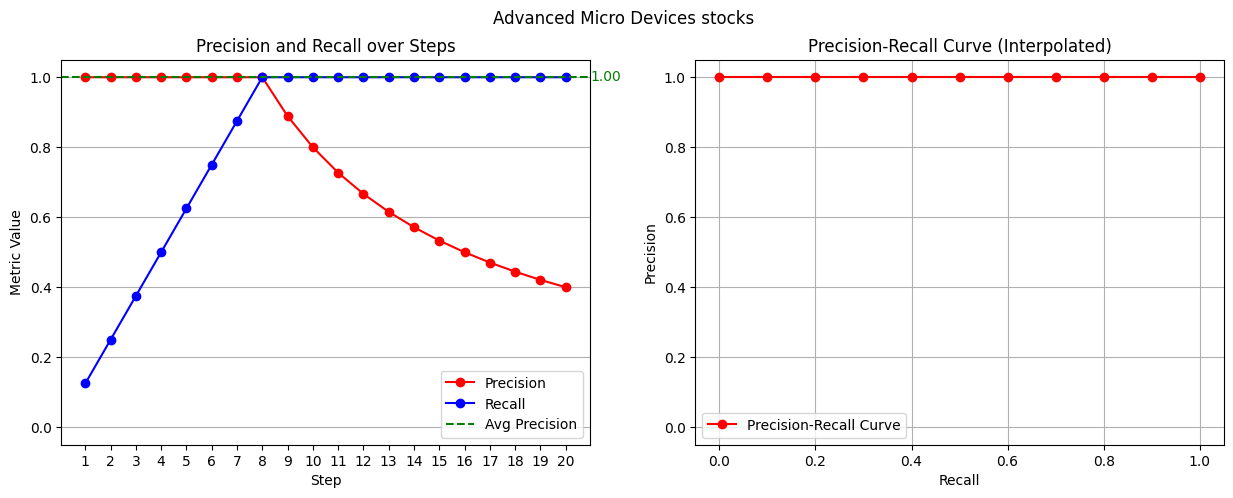

In [22]:
"""
From the previuous query, we will populate a list with the relevance of documents.
The relevance of a document is 1 if the document is relevant and 0 otherwise.
"""

relevance = [
    1, 1, 1, 1, 1,
    1, 1, 1, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0
]

calculate_and_display_metrics(relevance, num_results, 'Advanced Micro Devices stocks')

In [122]:
# CANCELA

# search for articles related with jira align solutions
params = {
    'q': "{!parent which='doc_type:article'} company_keywords:(jira align)",
    'fl': 'article_title article_companies [child] company_description',
    'rows': max_rows
}
results = solr.solr.search(**params)
num_results = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {len(results)}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        for company in result.get('article_companies'):
            solr.write_text(file, company.get('company_description'))
            file.write('\n')

print('file updated')

file updated


In [ ]:
"""
From the previuous query, we will populate a list with the relevance of documents.
The relevance of a document is 1 if the document is relevant and 0 otherwise.
"""

relevance = [
    1, 1, 1, 1, 1,
    1, 1, 1, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0
]

calculate_and_display_metrics(relevance, num_results, 'Advanced Micro Devices stocks')

In [77]:
"""
DEFAULT, running with schema_weak.json
Search for stock declines for Tesla
"""
params = {
    'defType': 'edismax',
    'qf': 'article_title article_text',
    'q': 'Tesla dipped', 
    'rows': max_rows
}
results = solr.solr.search(**params)
num_results_V1 = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {num_results_V1}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        solr.write_text(file, result.get('article_text'))

print('file updated')

file updated


In [78]:
"""
ADVANCED, running with schema.json & edismax
Search for stock declines for Tesla
"""
params = {
    'defType': 'edismax',
    'qf': 'article_title article_text',
    'q': 'Tesla dipped',
    'bq': 'article_text:Tesla^2',
    'rows': max_rows
}
results = solr.solr.search(**params)
num_results_V2 = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {num_results_V2}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        solr.write_text(file, result.get('article_text'))

print('file updated')

file updated


Average Precision:  0.7736111111111111
Interpolated Precisions:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.4, 0.4]


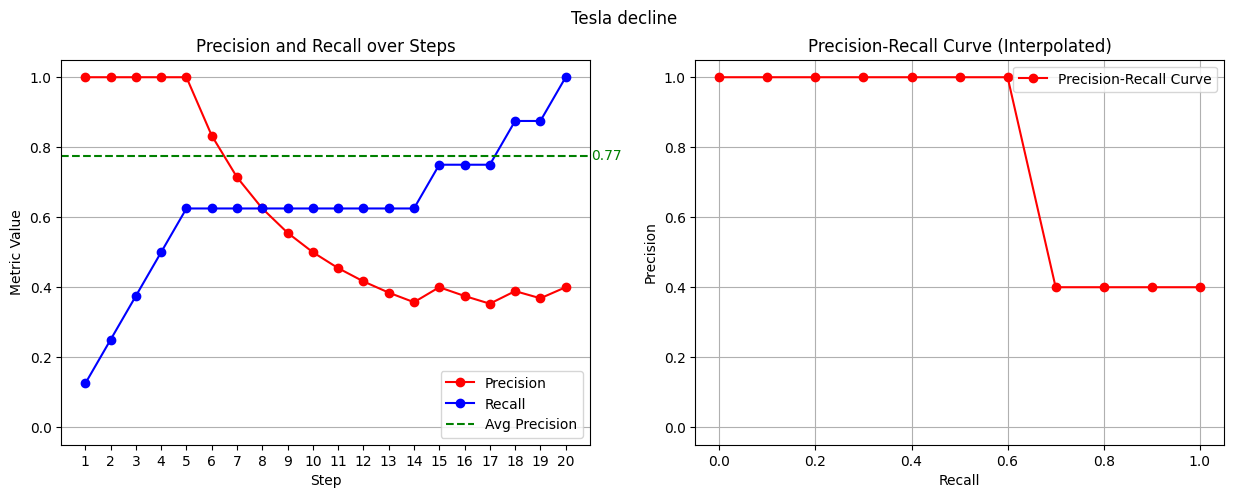

Average Precision:  0.9026105955202594
Interpolated Precisions:  [1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.85, 0.82, 0.82, 0.82]


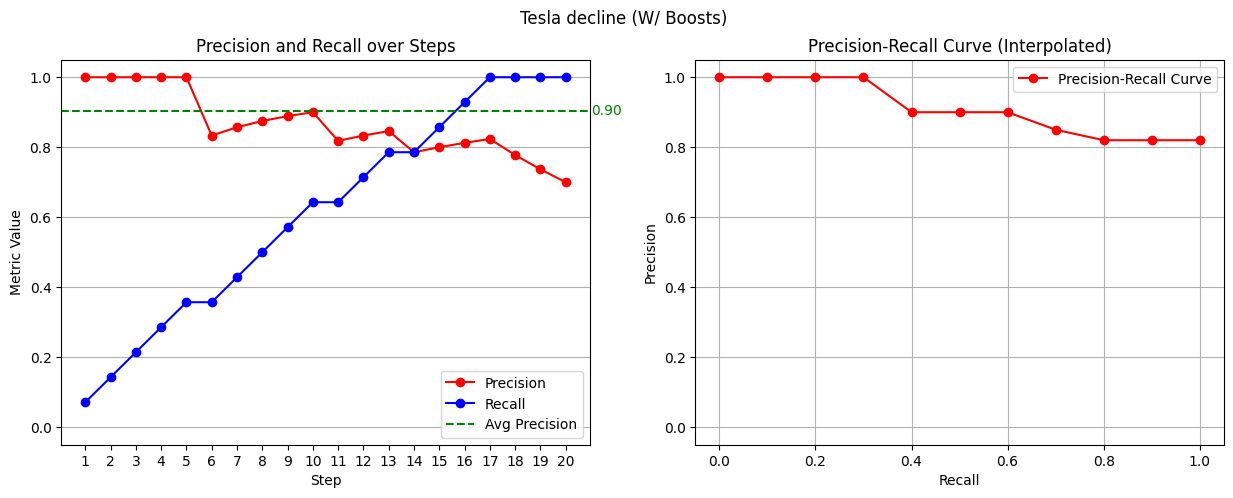

In [36]:
"""
From the previuous query, we will populate a list with the relevance of documents.
The relevance of a document is 1 if the document is relevant and 0 otherwise.
"""

relevance_V1 = [
    1, 1, 1, 1, 1,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 1,
    0, 0, 1, 0, 1
]

calculate_and_display_metrics(relevance_V1, num_results_V1, 'Tesla dipped')

relevance_V2 = [
    1, 1, 1, 1, 1,
    0, 1, 1, 1, 1,
    0, 1, 1, 0, 1,
    1, 1, 0, 0, 0
]

calculate_and_display_metrics(relevance_V2, num_results_V2, 'Tesla dipped (W/ Boosts)')

In [133]:
# CANCELA
# search for stock market predictions
params = {
    'defType': 'edismax',
    'qf': 'article_title article_text',
    'q': 'stock market predictions~3',
    'rows': max_rows,
    'mm': '70%'
}
results = solr.solr.search(**params)
num_results = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {len(results)}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        solr.write_text(file, result.get('article_text'))

print('file updated')

file updated


In [ ]:
"""
From the previuous query, we will populate a list with the relevance of documents.
The relevance of a document is 1 if the document is relevant and 0 otherwise.
"""

relevance = [
    1, 1, 1, 1, 0,
    1, 1, 0, 1, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 1, 1
]

calculate_and_display_metrics(relevance, num_results, 'Tesla decline')

In [131]:
# search for stock rises in artificial intelligence
params = {
    'q': 'company_keywords:"artificial intelligence" AND article_text:rising',
    'fl': 'article_title, article_text, article_companies, company_description',
    'rows': max_rows
}

results = solr.solr.search(**params)
num_results = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {len(results)}\n')
    for index, result in enumerate(results, start=1):
        print(result)
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        file.write(str(result.get('article_text')) + '\n\n')
        for company in result.get('article_companies'):
            solr.write_text(file, company.get('company_description'))
            file.write('\n')

print('file updated')

file updated


In [ ]:
"""
From the previuous query, we will populate a list with the relevance of documents.
The relevance of a document is 1 if the document is relevant and 0 otherwise.
"""

relevance = [
    1, 1, 1, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0
]

calculate_and_display_metrics(relevance, num_results, 'AI rising')

In [69]:
# TESTE
params = {
    'q': 'article_text:forecasting',
    'rows': max_rows
}
results = solr.solr.search(**params)
num_results_V2 = len(results)

with open(results_file, 'w', encoding='utf-8') as file:
    file.write('Parameters: ' + str(params) + '\n\n')
    file.write('--------------------------------------------------\n')
    file.write(f'Number of results: {num_results_V2}\n')
    for index, result in enumerate(results, start=1):
        file.write(f'------------------------ Result: {index} --------------------------\n\n')
        file.write(str(result.get('article_title')) + '\n\n')
        solr.write_text(file, result.get('article_text'))

print('file updated')

file updated


In [16]:
solr.close()

Solr container with core articles stopped successfully.
